Ссылка на датасет:
https://www.kaggle.com/c/aptos2019-blindness-detection/data

In [2]:
import os
import shutil
import re
import math

import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import metrics
from random import shuffle, sample, randint
from glob import glob

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import VGG16

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array



from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, confusion_matrix

import cv2

from matplotlib import pyplot as plt
%matplotlib inline

#tf.debugging.set_log_device_placement(True)

2.1.0


# Чтение данных

In [3]:
#base_image_dir = os.path.join('..', 'input/aptos2019-blindness-detection/')
base_image_dir = 'D:\\made\\int'
train_dir = os.path.join(base_image_dir, 'train_images\\')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df.head()

,id_code,diagnosis,path
0,000c1434d8d7,2,D:\made\int\train_images\000c1434d8d7.png
1,001639a390f0,4,D:\made\int\train_images\001639a390f0.png
2,0024cdab0c1e,1,D:\made\int\train_images\0024cdab0c1e.png
3,002c21358ce6,0,D:\made\int\train_images\002c21358ce6.png
4,005b95c28852,0,D:\made\int\train_images\005b95c28852.png


In [4]:
test_dir = os.path.join(base_image_dir,'test_images\\')
df_test = pd.read_csv(os.path.join(base_image_dir, 'test.csv'))
df_test['path'] = df_test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
df_test.head()

,id_code,path
0,0005cfc8afb6,D:\made\int\test_images\0005cfc8afb6.png
1,003f0afdcd15,D:\made\int\test_images\003f0afdcd15.png
2,006efc72b638,D:\made\int\test_images\006efc72b638.png
3,00836aaacf06,D:\made\int\test_images\00836aaacf06.png
4,009245722fa4,D:\made\int\test_images\009245722fa4.png


Посмотрим на баланс классов

In [5]:
df.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

Выборка несбалансированая

In [6]:
np.unique(df.diagnosis, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([1805,  370,  999,  193,  295], dtype=int64))

# Деление выборки

Поделим выорку на обучение, тест и валидацию:

In [7]:
image_train, im_test, y_train, y_tt = train_test_split(np.array(df.path), 
                                                            np.array(df.diagnosis), 
                                                            test_size=0.3,
                                                            random_state=123, 
                                                            stratify=df.diagnosis)


In [8]:
image_test, image_val, y_test, y_val = train_test_split(im_test, 
                                                        y_tt, 
                                                        test_size=100,
                                                        random_state=123, 
                                                        stratify=y_tt)

In [9]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([492, 101, 273,  53,  80], dtype=int64))

In [10]:
_, class_instances = np.unique(y_train, return_counts=True)
class_instances

array([1263,  259,  699,  135,  207], dtype=int64)

In [11]:
np.unique(y_val, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64), array([50, 10, 27,  5,  8], dtype=int64))

Запомним сколько элементов в самом маленьком классе

In [12]:
MIN_NUM = min(class_instances)
MIN_NUM

135

# Борьба с несбалансированностью классов

**ИДЕЯ:** Из каждого класса возьмем случайныс образом MIN_NUM элементов, перемешаем их и на этой сбалансированной выборке будем обучаться. Перед каждой эпохой будем создавать новую сбалансированную обучающую выборку.

Для этого создадим словарь вида:
{метка класса 0: список картинок,
метка класса 1: список картинок, ...}

In [13]:
sorted_paths_by_class = {}
for path, label in zip(image_train, y_train):
    if label in sorted_paths_by_class:
        sorted_paths_by_class[label].append(path)
    else:
        sorted_paths_by_class[label] = [path]

Создадим новую обучающую сбалансированную выборку:

In [14]:
def get_balanсe_train(dict_of_sorted_paths_train, len_sample=MIN_NUM):
    result = []
    for label, path_list in dict_of_sorted_paths_train.items():
        random_paths = sample(path_list, len_sample)   # случайным образом выбираем MIN_NUM число путей картинок
        result.extend(random_paths)
    shuffle(result)                          # перемешиваем выборку
    return result

Создадим словарь вида {путь_картинки : класс, ...} для быстрого доступа к метке класса по пути картинки

In [15]:
label_for_path_in_train = dict(zip(image_train, y_train))
label_for_path_in_val = dict(zip(image_val, y_val))
label_for_path_in_test = dict(zip(image_test, y_test))

# Предобработка данных:

In [16]:
IMG_SIZE = (224, 224)  # размер входного изображения сети
NUM_CLASSES = 5        # число классов
EPSILON = 0.5          # с такой вероятностью делаем поворот картинки

## Кодирование целевой переменной с учетом порядка над классами

Вместо того, чтобы решать задачу классификации с N классами (в нашем
случае N = 5), решим N-1 задачу бинарной классификации: найти вероятность того, что предсказанная метка t будет больше k, т.е. P (t > k ) , где
0 ≤ k ≤ N − 1 .

Так как между классами существует порядок, то закодируем классы следующим образом:

0  ->  \[0, 0, 0, 0 \]  
1  ->  \[1, 0, 0, 0 \]  
2  ->  \[1, 1, 0, 0 \]  
3  ->  \[1, 1, 1, 0 \]  
4  ->  \[1, 1, 1, 1 \]

При такой кодировке целевой переменной на выходе последнего слоя
нейронной сети используем сигмоиду как функцию активации, а в качестве
ошибки берем логистическую функцию потерь (binary cross-entropy)

In [17]:
def target_code(label, num_classes=NUM_CLASSES):
    vec = np.zeros((num_classes-1))
    vec[:label] = 1
    return vec

In [18]:
def rotate_image(image, angle):
    '''
    Функция, которая возвращает картинку, которую повернули на заданный угол
    '''
    col, row, _ = image.shape
    center=tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
    new_image = cv2.warpAffine(image, rot_mat, (row, col))
    return new_image

In [19]:
def crop_image_from_gray(img,tol=7):
    '''
    Обрезает темные края на картинке
    '''
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [20]:
def circle_crop(path, img_size=IMG_SIZE, sigmaX=10, is_train=False, is_plot=False):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(path)
    
    if is_train:                           # делаем поворот картинки только при обучении
        if np.random.random() < EPSILON:   # определяем будем ли поворачивать картинку
            angle = randint(1, 359)
            img = rotate_image(img, angle);
    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    img = cv2.resize(img, img_size)
    
    if is_plot:
        return img
    else:
        return preprocess_input(img)   # предобработка для VGG16

In [21]:
# генератор для последовательного чтения обучающих данных с диска
def fit_generator(dict_label_for_path, batch_size=45, is_train=True, files=image_train):
    while True:
        if is_train:
            files = get_balanсe_train(sorted_paths_by_class)   # Создать сбалансированную выборку
            shuffle(files)
        
        for k in range(math.ceil(len(files) / batch_size)):   # округляем до ближайшего целого вверх
            i = k * batch_size                                # k -- номер батча в проходе                      
            j = i + batch_size
            if j > len(files):
                j = len(files)
            x = np.array([circle_crop(path, is_train=is_train) for path in files[i:j]]) # картинки в виде матрицы
            label = np.array([dict_label_for_path[path] for path in files[i:j]])     # метки класса
            y = np.array([target_code(lab) for lab in label])      # кодирование целевой переменной
            yield (x, y)

In [22]:
# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    #while True:
        for path in files:
            
            yield np.array([circle_crop(path)])

# Визуализация примеров для обучения

Посмотрим как выглядят исходные данные

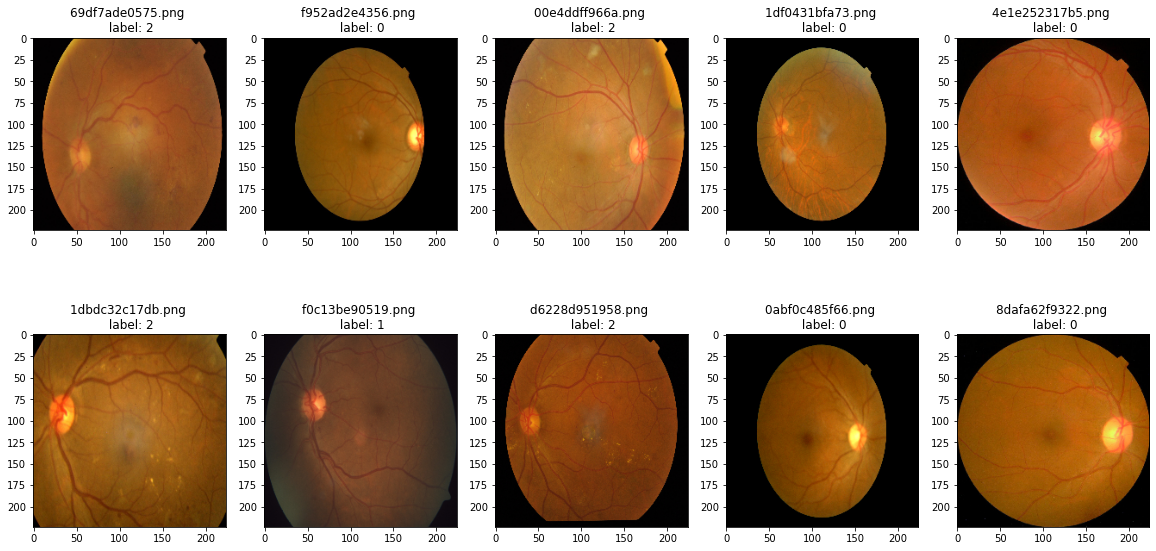

In [23]:
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(image_train[:10], 1):
    subplot = fig.add_subplot(math.ceil(i / 5), 5, i)
    plt.imshow(cv2.resize(plt.imread(path), IMG_SIZE));
    subplot.set_title('{} \n label: {}'.format(os.path.basename(path), label_for_path_in_train[path]))

А так они выглядят после предобработки:

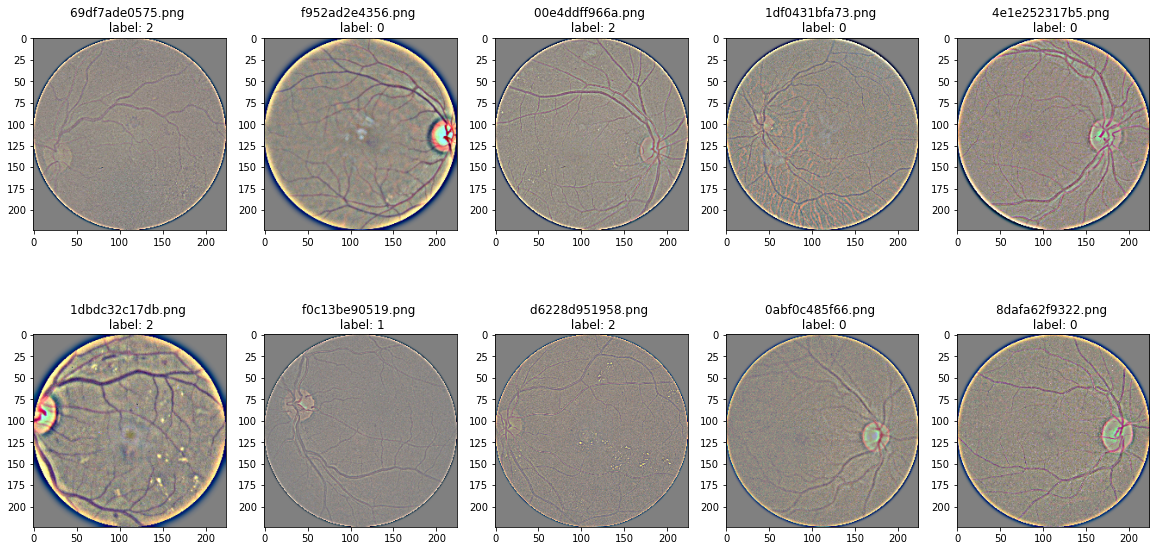

In [24]:
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(image_train[:10], 1):
    subplot = fig.add_subplot(math.ceil(i / 5), 5, i)
    plt.imshow(circle_crop(path, is_plot=True));
    subplot.set_title('{} \n label: {}'.format(os.path.basename(path), label_for_path_in_train[path]))

# Строим модель

Загружаем преобученную на датасете 'ImagNet' модель VGG16 

In [25]:

conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3) )

In [26]:
# фиксируем все веса предобученной сети кроме последнего блока 
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
model = models.Sequential()
model.add(conv_base)  # кусок VGG-16 добавлен в модель
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASSES-1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 100356    
Total params: 14,817,092
Trainable params: 2,461,188
Non-trainable params: 12,355,904
_________________________________________________________________


In [29]:
model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy',  # функция потерь 'binary_crossentropy'
              metrics=['accuracy'])

Загружаем веса

In [30]:
model.load_weights("vgg16_order_class.hdf5")

Визуализируем процесс обучения

In [31]:
def get_prob_of_label_in_one_pred(prediction):
    '''
    Возвращает вектор, элементами которого являются вероятности принадлежности к классу
    prediction = [a, b, c, d]
    prob_label = [p_0, p_1, p_2, p_3, p_4],  где p_i -- вероятность принадлежности к классу i
    
    p_0 = 1 - a
    p_1 = a - b
    p_2 = b - c
    p_3 = c - d
    p_4 = d
    '''
    prob_label = np.zeros(NUM_CLASSES)
    prob_label[0] = 1 - prediction[0]
    for i in range(1, NUM_CLASSES-1):
        prob_label[i] = prediction[i-1] - prediction[i]
    prob_label[-1] = prediction[-1]
    return prob_label

In [32]:
def get_vect_of_probas_label_in_pred(pred_of_model):
    '''
    Возвращает список списков вероятности принадлежности к классу для всех элементов выборки
    
    [[p0_0, p0_1, p0_2, p0_3, p0_4],
     [p1_0, p1_1, p1_2, p1_3, p1_4],
     ...
    ]
    '''
    return list(map(lambda x: get_prob_of_label_in_one_pred(x), pred_of_model))

In [34]:

pred = model.predict(predict_generator(image_test[[996,371,991,987,966,268]]), max_queue_size=500)

In [35]:
probas_labels = np.array(get_vect_of_probas_label_in_pred(pred))

LIME

In [47]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

Вспомогательные функции для трансформации изображений перед наложением масок вывода результата для двух классов

In [48]:
import random

def resize_as_sample(img, img_size=IMG_SIZE, sigmaX=10,): 
    #img = img.astype('uint8')
    img = crop_image_from_gray(img)   
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape    

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y)) 
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    #img = cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    img = cv2.resize(img, img_size)
    return img

def pred2(img):
    try:
        res = model.predict([img])
        #print(res)
    except Exception as e:
        print(e)
        res = np.array([0, 0])
    r = []
    for r0 in res:

        #r.append(get_prob_of_label_in_one_pred(r0))
        #print(r0)
        r.append([get_prob_of_label_in_one_pred(r0)[0],max(get_prob_of_label_in_one_pred(r0)[1:]) ])
    return np.array(r)

In [49]:
explainer = lime_image.LimeImageExplainer()

  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

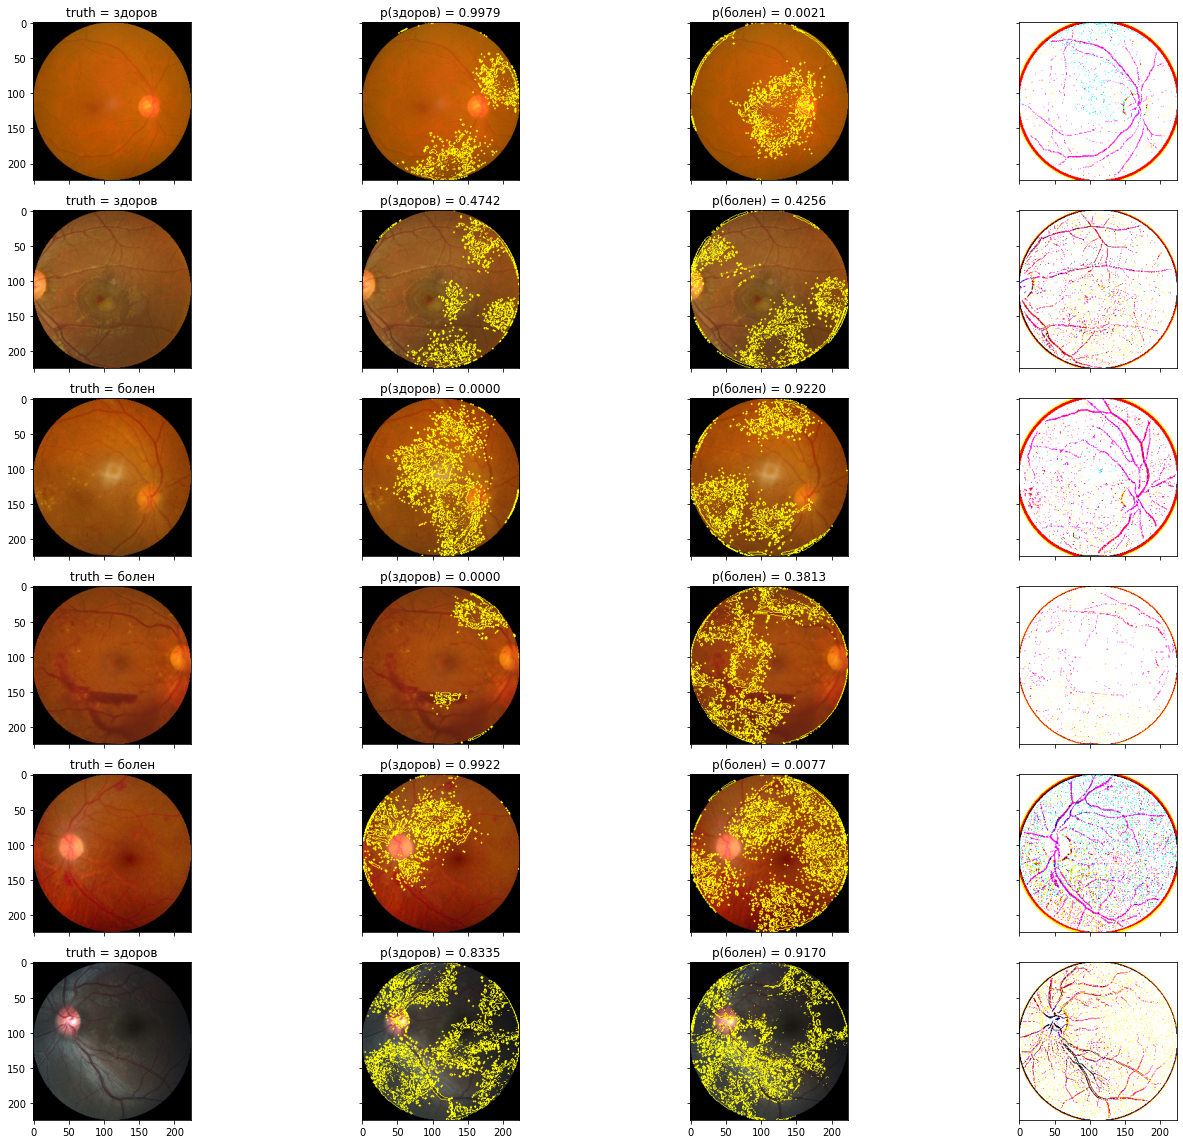

Wall time: 44.7 s


In [50]:
%%time
plt.clf()


fig, ax = plt.subplots(6, 4, sharex='col', sharey='row')

fig.set_figwidth(20)
fig.set_figheight(16)
def outcome(n):
    if n ==0 :
        return 'здоров'
    if n > 0 :
        return 'болен'
    
with tf.device('/GPU:0'):
    n=0
    for j in [996,371,991,987,966,268]:
        j-=1

        explanation = explainer.explain_instance([x for x in predict_generator([image_test[j]])][0][0].astype('double') 
                                           ,pred2 ,top_labels=2, batch_size=5,num_samples=100,
                                             segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,mask = circle_img,
                                                    max_dist=200,sigma=1, ratio=0.2,multichannel=True,n_segments = 20,convert2lab=True,
                                               start_labelint=0,     random_seed=42))
        
        ax[n,0].imshow(resize_as_sample(cv2.imread(image_test[j]),IMG_SIZE ))
        ax[n,0].set_title('truth = '+ outcome(label_for_path_in_test[image_test[j]]))

            
        for i in range(2):
            res = pred2([x for x in predict_generator(image_test[j:j+1])][0])[0][i]
            temp, mask = explanation.get_image_and_mask(i, positive_only=True, 
                                                        num_features=10*(2*i+1), hide_rest=False)
            ax[n,i+1].imshow(mark_boundaries(resize_as_sample(cv2.imread(image_test[j])), mask))
            ax[n,i+1].set_title('p({}) = {:.4f}'.format( outcome(i),(res)))
        ax[n,3].imshow([x for x in predict_generator([image_test[j]])][0][0])
        n+=1
        
plt.tight_layout()
plt.show()      

          